In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [2]:
data = pd.read_csv('Air_Passengers.csv')
data['Month'] = pd.to_datetime(data['Month'],infer_datetime_format=True)
indexed_data = data.set_index(['Month'])
indexed_data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


C:\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


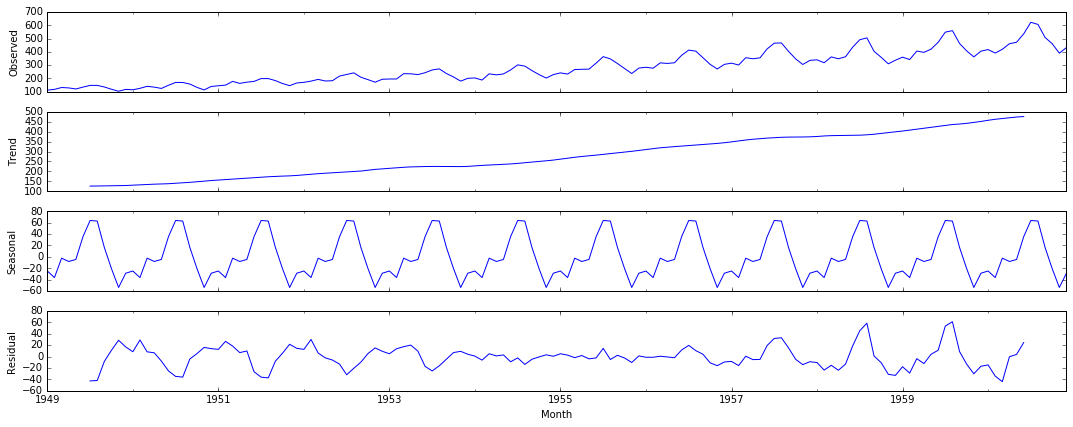

In [3]:
result = seasonal_decompose(indexed_data, model='additive')
fig = result.plot()

In [4]:
def rollinganddf_test(dataset,std_dev=True):
    mean = dataset.rolling(window=12).mean()
    std = dataset.rolling(window=12).std()
    
    orig = plt.plot(dataset,color='Blue',label='Original')
    mean = plt.plot(mean, color='Red',label='Rolling Mean')
    if std_dev:
        std = plt.plot(std,color='Black',label='Rolling Stddev')
        plt.title('Rolling Mean with Standard deviation')
    else:
        plt.title('Rolling Mean')
    plt.legend(loc='best')
    plt.show()
    
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(dataset['#Passengers'],autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Vlaue (%s)' %key] = value
    return dfoutput

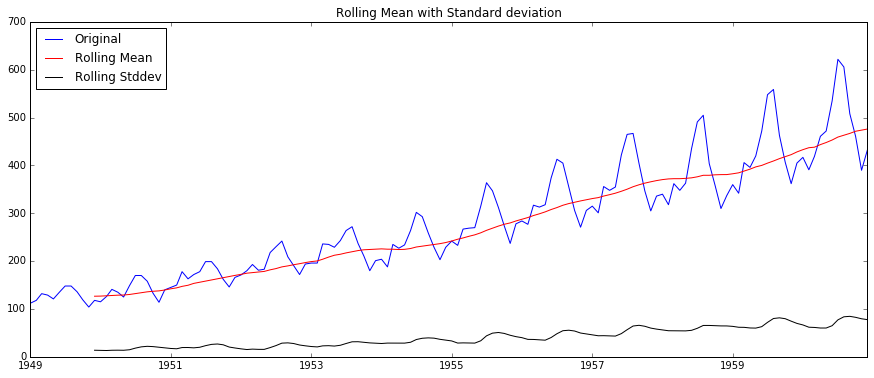

Result of Dickey-Fuller Test:


Test Statistics                  0.815369
p-value                          0.991880
Lags Used                       13.000000
Number of Observations Used    130.000000
Critical Vlaue (10%)            -2.578770
Critical Vlaue (5%)             -2.884042
Critical Vlaue (1%)             -3.481682
dtype: float64

In [5]:
rollinganddf_test(indexed_data)

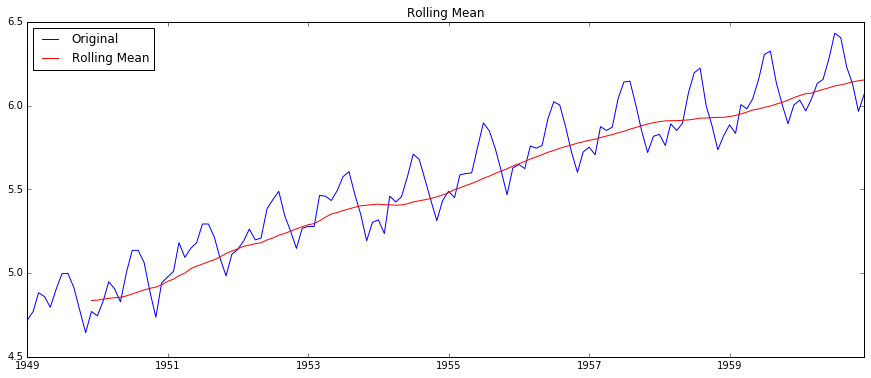

Result of Dickey-Fuller Test:


Test Statistics                 -1.717017
p-value                          0.422367
Lags Used                       13.000000
Number of Observations Used    130.000000
Critical Vlaue (10%)            -2.578770
Critical Vlaue (5%)             -2.884042
Critical Vlaue (1%)             -3.481682
dtype: float64

In [6]:
indexed_datalog = np.log(indexed_data)
rollinganddf_test(indexed_datalog,False)

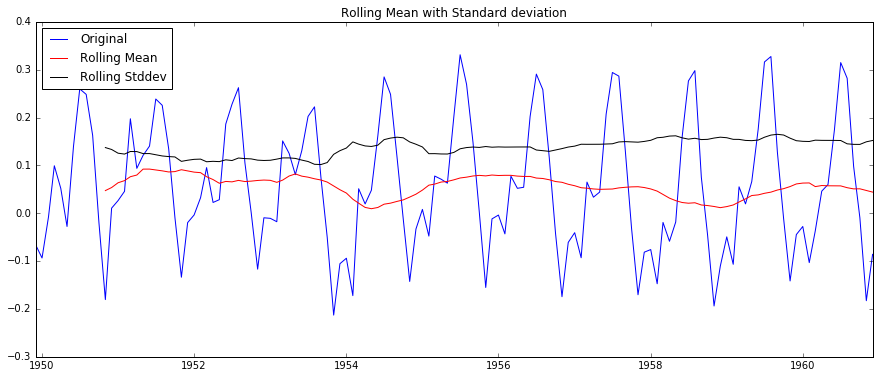

Result of Dickey-Fuller Test:


Test Statistics                 -3.162908
p-value                          0.022235
Lags Used                       13.000000
Number of Observations Used    119.000000
Critical Vlaue (10%)            -2.579896
Critical Vlaue (5%)             -2.886151
Critical Vlaue (1%)             -3.486535
dtype: float64

In [7]:
rollmean_log = indexed_datalog.rolling(window=12).mean()
indexed_datalog_minus_mean = indexed_datalog - rollmean_log
indexed_datalog_minus_mean.dropna(inplace=True)
rollinganddf_test(indexed_datalog_minus_mean)

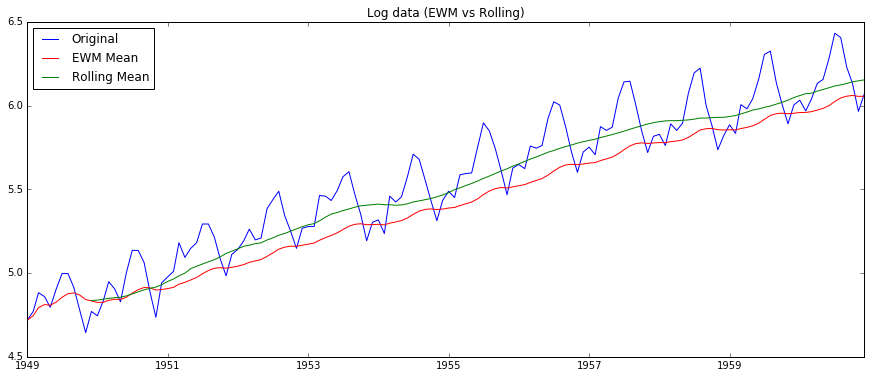

In [8]:
indexed_datalog_ewm_mean= indexed_datalog.ewm(halflife=12,min_periods=0,adjust=True).mean()
orig = plt.plot(indexed_datalog,color='Blue',label='Original')
ewm_mean = plt.plot(indexed_datalog_ewm_mean, color='Red',label='EWM Mean')
roll_mean = plt.plot(rollmean_log, color='Green',label='Rolling Mean')
plt.title('Log data (EWM vs Rolling)')
plt.legend(loc='best')
plt.show()

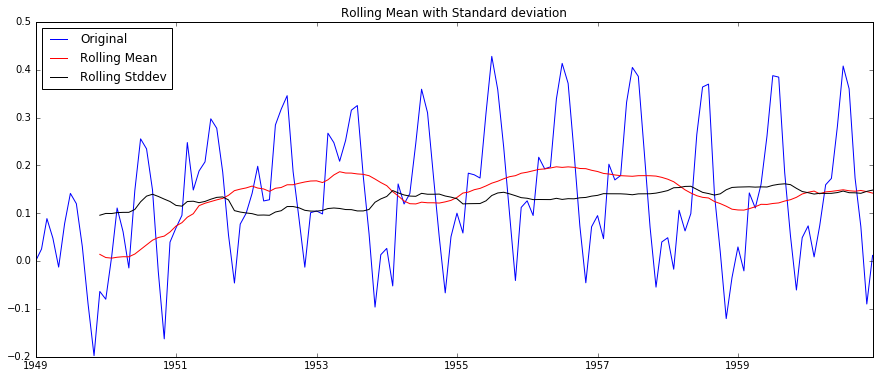

Result of Dickey-Fuller Test:


Test Statistics                 -3.601262
p-value                          0.005737
Lags Used                       13.000000
Number of Observations Used    130.000000
Critical Vlaue (10%)            -2.578770
Critical Vlaue (5%)             -2.884042
Critical Vlaue (1%)             -3.481682
dtype: float64

In [9]:
indexed_datalog_minus_ewm_mean = indexed_datalog - indexed_datalog_ewm_mean
rollinganddf_test(indexed_datalog_minus_ewm_mean)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


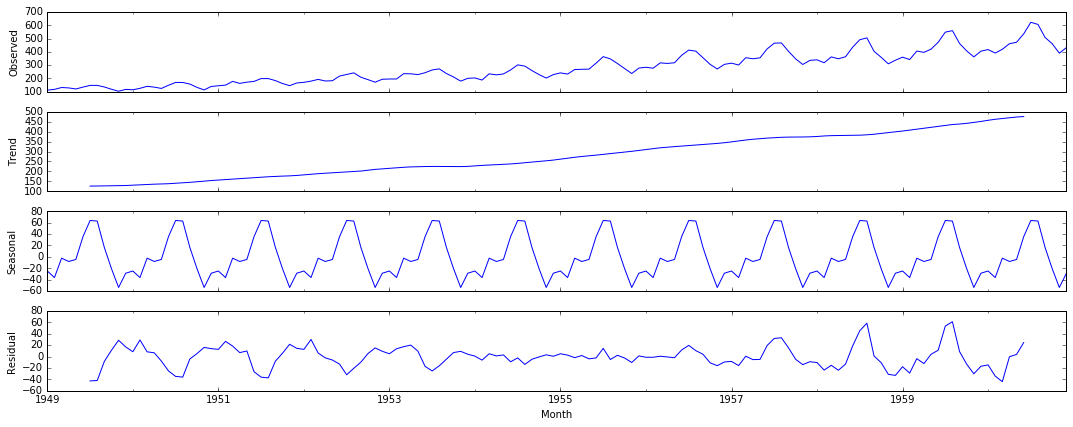

In [10]:
decomposition = seasonal_decompose(indexed_datalog, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig = result.plot()

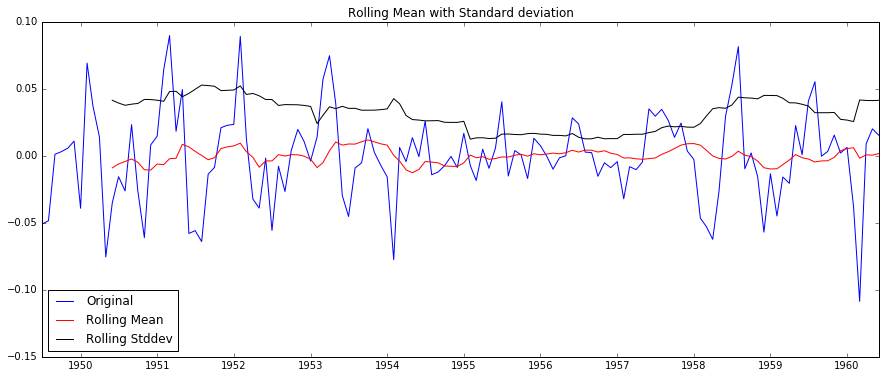

Result of Dickey-Fuller Test:


Test Statistics               -6.332387e+00
p-value                        2.885059e-08
Lags Used                      9.000000e+00
Number of Observations Used    1.220000e+02
Critical Vlaue (10%)          -2.579569e+00
Critical Vlaue (5%)           -2.885538e+00
Critical Vlaue (1%)           -3.485122e+00
dtype: float64

In [11]:
residual.dropna(inplace=True)
rollinganddf_test(residual)

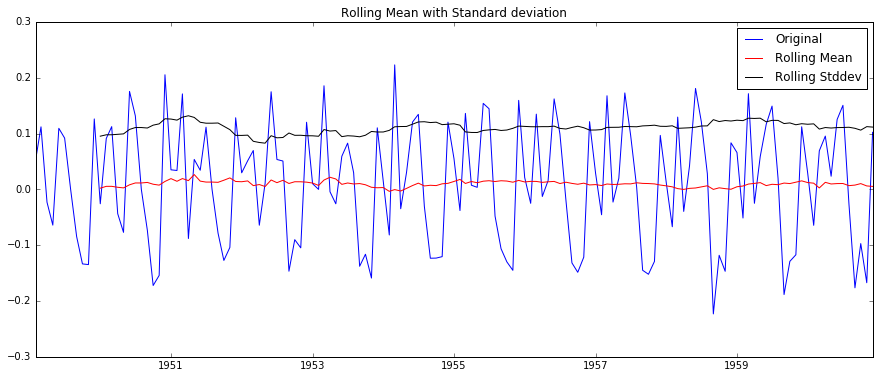

Result of Dickey-Fuller Test:


Test Statistics                 -2.717131
p-value                          0.071121
Lags Used                       14.000000
Number of Observations Used    128.000000
Critical Vlaue (10%)            -2.578960
Critical Vlaue (5%)             -2.884398
Critical Vlaue (1%)             -3.482501
dtype: float64

In [12]:
indexed_datalog_shift = indexed_datalog - indexed_datalog.shift()
indexed_datalog_shift.dropna(inplace=True)
plt.title('Log Shift difference')
rollinganddf_test(indexed_datalog_shift)

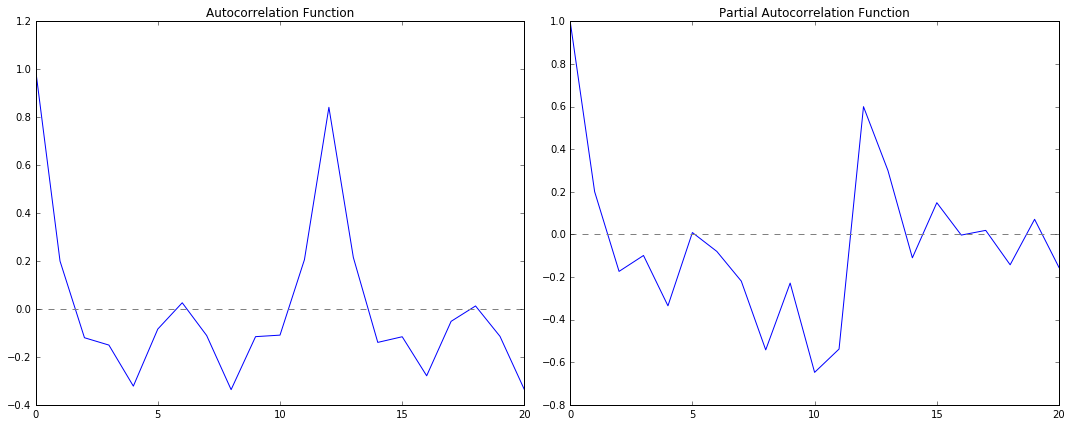

In [13]:
lag_acf = acf(indexed_datalog_shift, nlags=20)
lag_pacf = pacf(indexed_datalog_shift, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

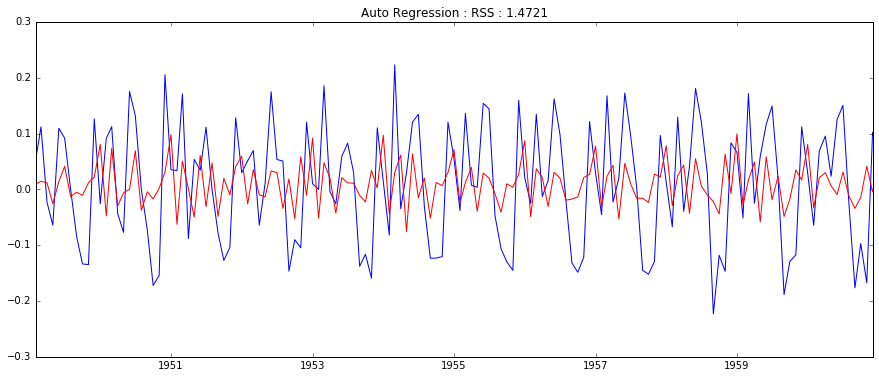

In [14]:
model_AR = ARIMA(indexed_datalog,order=(0,1,2))
result_AR = model_AR.fit(disp=-1)
plt.plot(indexed_datalog_shift)
plt.plot(result_AR.fittedvalues, color='red')
plt.title('Auto Regression : RSS : %.4f' %sum((result_AR.fittedvalues - indexed_datalog_shift['#Passengers'])**2))
plt.show()

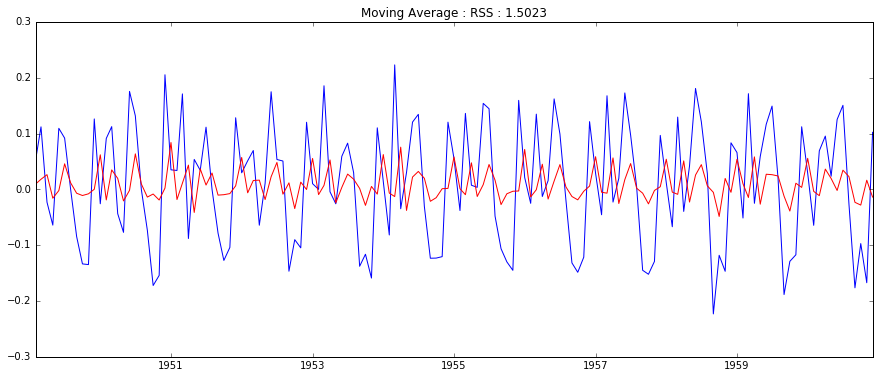

In [15]:
model_MA = ARIMA(indexed_datalog,order=(2,1,0))
result_MA = model_MA.fit(disp=-1)
plt.plot(indexed_datalog_shift)
plt.plot(result_MA.fittedvalues, color='red')
plt.title('Moving Average : RSS : %.4f' %sum((result_MA.fittedvalues - indexed_datalog_shift['#Passengers'])**2))
plt.show()

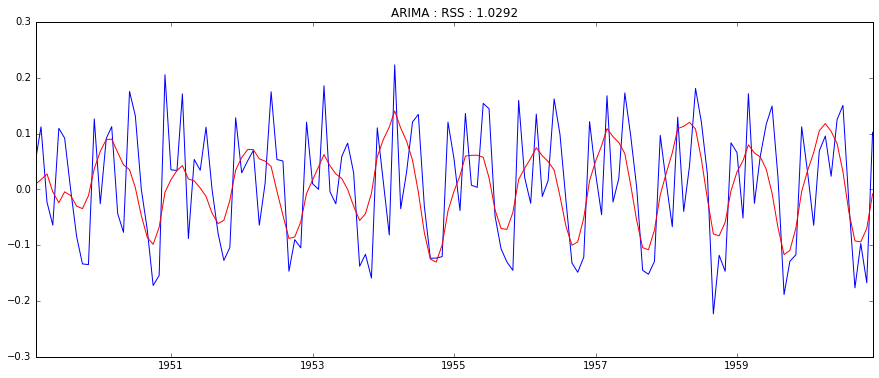

In [16]:
model = ARIMA(indexed_datalog,order=(2,1,2))
result_ARIMA = model.fit(disp=-1)
plt.plot(indexed_datalog_shift)
plt.plot(result_ARIMA.fittedvalues, color='red')
plt.title('ARIMA : RSS : %.4f' %sum((result_ARIMA.fittedvalues - indexed_datalog_shift['#Passengers'])**2))
plt.show()

In [17]:
pred_ARIMA_diff = pd.Series(result_ARIMA.fittedvalues, copy=True)
pred_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [18]:
pred_ARIMA_diff_cumsum = pred_ARIMA_diff.cumsum()
pred_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [19]:
pred_ARIMA_log = pd.Series(indexed_datalog['#Passengers'].ix[0], index=indexed_datalog.index)
pred_ARIMA_log = pred_ARIMA_log.add(pred_ARIMA_diff_cumsum, fill_value=0)
pred_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

In [20]:
pred_ARIMA = np.exp(pred_ARIMA_log)
pred_ARIMA.head()

Month
1949-01-01    112.000000
1949-02-01    113.078122
1949-03-01    115.073416
1949-04-01    118.301990
1949-05-01    117.768368
dtype: float64

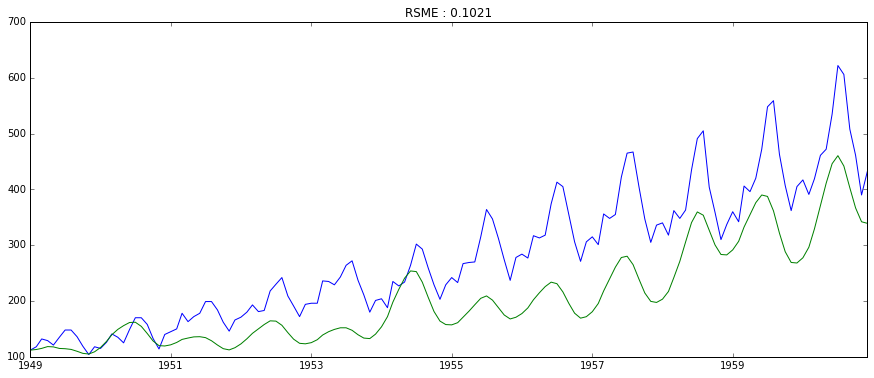

In [21]:
plt.plot(indexed_data)
plt.plot(pred_ARIMA)
plt.title('RSME : %.4f' % np.sqrt(sum((result_MA.fittedvalues - indexed_datalog_shift['#Passengers'])**2)/len(indexed_data)))
plt.show()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


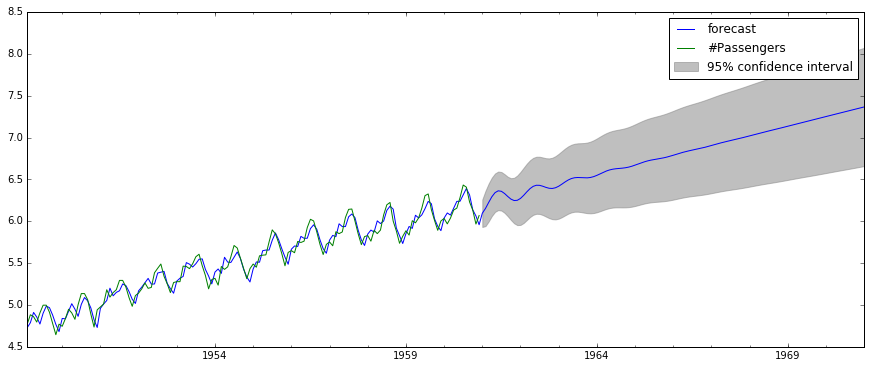

In [22]:
fig = result_ARIMA.plot_predict(1,264)
plt.show()

In [23]:
result_ARIMA.forecast(steps=120)

(array([ 6.09553388,  6.15281397,  6.2244296 ,  6.29241098,  6.34164718,
         6.36359368,  6.35784695,  6.33139315,  6.29597551,  6.26447722,
         6.2473833 ,  6.25025172,  6.27275833,  6.30940308,  6.35151491,
         6.38988656,  6.41727385,  6.43011061,  6.42906699,  6.41842499,
         6.40456164,  6.39403622,  6.39183086,  6.40019504,  6.41833692,
         6.44295408,  6.46937437,  6.4929399 ,  6.51024126,  6.51989042,
         6.52267588,  6.52112396,  6.51864534,  6.51853695,  6.52311927,
         6.53322364,  6.54812873,  6.56591561,  6.58410314,  6.60036547,
         6.61313275,  6.6219279 ,  6.62737798,  6.63093137,  6.63438697,
         6.63937992,  6.64696511,  6.65739847,  6.67015331,  6.68414258,
         6.69806634,  6.7107791 ,  6.72157741,  6.73033993,  6.7374982 ,
         6.74386388,  6.75037332,  6.75782601,  6.7666869 ,  6.77699831,
         6.78841328,  6.80032863,  6.81207204,  6.8230877 ,  6.83307147,
         6.84202503,  6.85022323,  6.85811231,  6.8